In [1]:
# import pandana
# import osmnx as ox
import geopandas as gpd
from sqlalchemy import create_engine
import psycopg2
import pandas as pd
import geoalchemy2
import numpy as np
import networkx as nx

D:\Temp\ipykernel_5112\3908045456.py:3: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
# функция для чтения того, что получили в запросе
def select_pg(sql, geom):
    return gpd.read_postgis(sql, engine, geom_col = geom, crs = 3857)

engine = create_engine('postgresql+psycopg2://kb_geo:kYZQK90yvE8aNi54ELINc0yJ1gu6wo7h@\
db03.cluster.strlk.ru/kb_geo')

sql = "SELECT * FROM strelka_data_russia.vk_photo_2022_meta where (photo_region = 'Иркутская область' or photo_region = 'Республика Бурятия')  and owner_id !=0"
photo = select_pg(sql, 'geom')

#убираем те фотографии где owner_id равен нулю (это фотографии из групп)
photo = photo[photo['owner_id'] != 0]
#убираем те фотографии где город пользователя не указан 
photo = photo[photo['city'].notna()]
#убираем те фотографии где город пользователя равен городу фотографирование 
photo_main = photo[photo['city'] != photo['photo_city']]
#преоброзоавние колонки со датой и временем в нормальный вид 
photo_main['date_time'] = pd.to_datetime(photo_1['date_time'], format='%Y-%m-%d %H:%M:%S')

In [3]:
#подключаемся к базе куда хотим положить фотографии
def select_pg(sql):
    return pd.read_sql(sql, engine)

engine = create_engine('postgresql+psycopg2://kb_geo:kYZQK90yvE8aNi54ELINc0yJ1gu6wo7h@\
db03.cluster.strlk.ru/kb_graph')

In [578]:
sql = "SELECT id, rang, lng, lat FROM baikal_attractor"
baikal_attractor = select_pg(sql)
baikal_attractor['rang'].value_counts()

In [ ]:
#все летние фотографии 
photo_main[(photo_main['month'] >= 5) & (photo_main['month'] <= 10)]

#все зимние фотографии 
photo_main[(photo_main['month'] < 5) | (photo_main['month'] > 10)]

In [13]:
# cтатистика по месяцам у всех пользователей (график)

statistic_month = photo_main['month'].value_counts().reset_index().rename({'index':'month', 'month':'count'})
statistic_month = statistic_month.sort_values('index').rename(columns = {'index':'month', 'month':'count'})
statistic_month.set_index('month').plot()

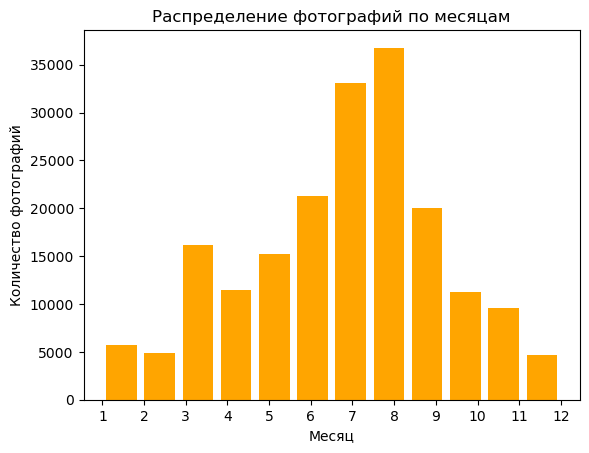

In [20]:
# cтатистика по месяцам у всех пользователей (красивая гистрограмма)

import matplotlib.pyplot as plt

plt.hist(photo_main['month'], color='orange', rwidth=0.8, bins=12)
plt.xlabel('Месяц')
plt.ylabel('Количество фотографий')
plt.title('Распределение фотографий по месяцам')
plt.xticks(np.arange(1, 13), np.arange(1, 13))
plt.show()

In [ ]:
#создание гексагонов из фотографий (размер 7)

photo_hex = (photo_main
 .assign(count=1)
 .h3.geo_to_h3_aggregate(7))

# photo_winter_hex.to_file('photo_winter_hex.geojson')

In [ ]:
#читаем таблицу со всеми дорогами на байкале 

sql = "SELECT * FROM baikal_edges"
baikal_edges_all = select_pg(sql, 'geom')
baikal_edges_all['distant'] = baikal_edges_all['geom'].length.round()

#создание графа 
# G = nx.from_pandas_edgelist(baikal_edges_all, 'u', 'v', edge_attr='distant')

In [441]:
baikal_edges_all['buffer'] = baikal_edges_all['geom'].buffer(100)

In [442]:
baikal_edges_all_buffer = gpd.GeoDataFrame(baikal_edges_all, geometry = baikal_edges_all['buffer'])

In [451]:
from shapely import wkt
import pandas as pd

In [443]:
baikal_edges_all_buffer_photo = baikal_edges_all_buffer.sjoin(baikal_luster_photo_owner_id, how='left', predicate='intersects')

ValueError: 'right_df' should be GeoDataFrame, got <class 'pandas.core.frame.DataFrame'>

In [455]:
G = nx.from_pandas_edgelist(baikal_edges_all, 'u', 'v', edge_attr='distant')
G.add_edge(648761618, 648761645, distant=2100)
edge_graph = nx.to_pandas_edgelist(G, source='source', target='target', nodelist=None, dtype=None, edge_key=None)

In [89]:
#считываем все дороги на байкале 
sql = "SELECT * FROM baikal_edges"
baikal_edges_all = select_pg(sql, 'geom')
#округляем длину дорог для более быстрых расчетов 
baikal_edges_all['distant'] = baikal_edges_all['geom'].length.round()
#создаем граф из ребер, определяем вес как расстояние 
G = nx.from_pandas_edgelist(baikal_edges_all, 'u', 'v', edge_attr='distant')
#все сабграфы записываем в лист 
S = [G.subgraph(c).copy() for c in nx.connected_components(G)]

# Создание пустого датафрейма
combined_df = pd.DataFrame(columns=['source', 'target', 'subgraph'])

# Цикл по всем subgraph
for i, subgraph in enumerate(S):
    # Преобразование подграфа в датафрейм
    df = pd.DataFrame(list(subgraph.edges()), columns=['source', 'target'])
    # Добавление столбца с идентификатором подграфа
    df['subgraph'] = i
    # Объединение с общим датафреймом
    combined_df = pd.concat([combined_df, df], axis=0, ignore_index=True)


road = combined_df.merge(baikal_edges_all, left_on = ['source', 'target'], right_on = ['u', 'v'])
road['subgraph'] = road['subgraph'].astype(int)
road = gpd.GeoDataFrame(road, geometry = road.geom, crs="EPSG:3857")
road_filter = road['subgraph'].value_counts().reset_index()[road['subgraph'].value_counts().reset_index()['subgraph'] > 1000]
road_itog = road.merge(road_filter, left_on = 'subgraph', right_on = 'index')

#получаем датафрэйм из всех графов, но с указанием к какому подграфу относится
road_itog[['u', 'v', 'subgraph_x', 'geometry']].to_file('baikal_edges_all_new.geojson')
